In [25]:
import os
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u
from queries import Simbad
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages
import itertools
% matplotlib inline
x1d_dir='/DataDisk/datafiles/PGCC_HST/x1d_files/'

# Returns the velocity shift necessary to convert Helio to LSR
# i.e. returns (V_lsr - V_helio)
def HelioToLSR(target_ra_deg, target_dec_deg):
    Vsun=19.7
    a0=271.0
    d0=30.0
    shift=Vsun*(np.cos(target_ra_deg-a0)*np.cos(a0)*np.cos(target_ra_deg)+np.sin(d0)*np.sin(target_dec_deg))
    return shift

#Returns angular separation between two Ra/Dec coordinates in degrees
def get_ang_sep(ra1,dec1,ra2,dec2):
    ra1_rad=ra1*np.pi/180.
    dec1_rad=dec1*np.pi/180.
    ra2_rad=ra2*np.pi/180.
    dec2_rad=dec2*np.pi/180.

    del_ra=ra2_rad-ra1_rad
    del_ras=np.sin(del_ra)
    del_rac=np.cos(del_ra)
    dec1s=np.sin(dec1_rad)
    dec2s=np.sin(dec2_rad)
    dec1c=np.cos(dec1_rad)
    dec2c=np.cos(dec2_rad)

    return (180./np.pi)*np.arctan(np.sqrt((dec2c**2)*(del_ras**2)+(dec1c*dec2s-dec1s*dec2c*del_rac)**2)/(dec1s*dec2s+dec1c*dec2c*del_rac))


class LineInfo(object):
    def __init__(self,dat_line,err_line):
        dat=dat_line.split()
        self.ion=dat[0]
        self.n=float(dat[1])
        self.b=float(dat[2])
        self.wav=float(dat[3])
        self.v=float(dat[4])
        self.n_flag=int(dat[5])
        self.b_flag=int(dat[6])
        self.v_flag=int(dat[7])
        self.eqw=float(dat[8])
        self.tot_eqw=float(dat[9])
        
        errs=err_line.split()
        self.n_err=float(errs[0])
        self.b_err=float(errs[1])
        self.v_err=float(errs[2])
        
    def __repr__(self):
        return self.ion
    def __str__(self):
        return self.ion

In [4]:
hdulist=fits.open('/DataDisk/datafiles/PGCC_HST/HFI_PCCS_GCC_R2.02.fits')
pgccs=hdulist[1].data

In [5]:
folders=[x for x in os.listdir(x1d_dir) if (os.path.isdir(x1d_dir+x) and x.startswith('.')==False)]                
ras=[]
decs=[]
nearest_pgccs=[]
for folder in folders:
    ra,dec=Simbad.Position(folder)
    ras.append(ra)
    decs.append(dec)
    nearest=100
    nearest_pgcc=[]
    for pgcc in pgccs:
        if abs(pgcc['ra']-ra.value)<1 and abs(pgcc['dec']-dec.value)<1:
            ang_sep=get_ang_sep(ra.value,dec.value,pgcc['ra'],pgcc['dec'])
            if ang_sep<0.5:
                nearest=ang_sep
                nearest_pgcc.append(pgcc)
    nearest_pgccs.append(nearest_pgcc)

In [6]:
coords=SkyCoord(ra=ras,dec=decs).galactic
ls=coords.l.value
bs=coords.b.value

In [7]:
sightlines=zip(folders,ls,bs,nearest_pgccs)

In [37]:
thrumms_path='/DataDisk/datafiles/PGCC_HST/CO/ThrUMMS/'
good_data=['HD114886','HD115071','HD116781','HD124314','HD148937']
pdf=PdfPages('thrumms_test.pdf')
vel_width=10.
for sl in [x for x in sightlines if x[0] in good_data]:
    cen_l=sl[1]
    cen_b=sl[2]
    icrs=SkyCoord(l=cen_l*u.degree,b=cen_b*u.degree, frame='galactic').icrs
    box=1.0
    results_files=[x for x in os.listdir(x1d_dir+sl[0]+'/E140H') if x.startswith('co') and x.endswith('_results.txt')]
    if len(results_files)>0:
        f=open(x1d_dir+sl[0]+'/E140H/'+results_files[0])
        lines=[x.strip() for x in f.read().split('\n')]
        for i in range(len(lines)):
            if lines[i].startswith('CO'):
                line_data=LineInfo(lines[i],lines[i+1])
                helio_vel=line_data.v
                break
    else:
        helio_vel=0.
    
    vel=helio_vel+HelioToLSR(icrs.ra.value,icrs.dec.value)
    min_vel=vel-vel_width
    max_vel=vel+vel_width

    filenames=['dr3.s'+str(300+6*i)+'.12co.fits' for i in range(10)]
    for filename in filenames:
        hdulist=fits.open(thrumms_path+filename)
        thrumms_hdr=hdulist[0].header
        thrumms_data=hdulist[0].data
        glon_naxis=thrumms_hdr['naxis1']
        glon_crpix=thrumms_hdr['crpix1']
        glon_crval=thrumms_hdr['crval1']
        glon_cdelt=thrumms_hdr['cdelt1']
        glons=[glon_crval+i*glon_cdelt for i in range(-glon_naxis/2,glon_naxis/2)]

        glat_naxis=thrumms_hdr['naxis2']
        glat_crpix=thrumms_hdr['crpix2']
        glat_crval=thrumms_hdr['crval2']
        glat_cdelt=thrumms_hdr['cdelt2']
        glats=[glat_crval+i*glat_cdelt for i in range(-glat_naxis/2,glat_naxis/2)]

        vel_naxis=thrumms_hdr['naxis3']
        vel_crpix=thrumms_hdr['crpix3']
        vel_crval=thrumms_hdr['crval3']
        vel_cdelt=thrumms_hdr['cdelt3']
        vels=[(vel_crval+i*vel_cdelt)/1000. for i in range(-vel_naxis/2,vel_naxis/2)]
        min_vel_idx=min(range(len(vels)), key=lambda i: abs(vels[i]-min_vel))
        max_vel_idx=min(range(len(vels)), key=lambda i: abs(vels[i]-max_vel))
        if (glons[-1] < cen_l < glons[0] and glats[0]< cen_b < glats[-1]):
            # Isolate a 1x1 deg box around the sightline
            min_glon=min(range(len(glons)),key=lambda i: abs(glons[i]-(cen_l+box/2.)))
            max_glon=min(range(len(glons)),key=lambda i: abs(glons[i]-(cen_l-box/2.)))
            min_glat=min(range(len(glats)),key=lambda i: abs(glats[i]-(cen_b-box/2.)))
            max_glat=min(range(len(glats)),key=lambda i: abs(glats[i]-(cen_b+box/2.)))
            dat=np.sum(thrumms_data[min_vel_idx:max_vel_idx,min_glat:max_glat,min_glon:max_glon],axis=0)
            dat=dat[::-1,:]
            #dat[np.isnan(dat)]=0
            dat[dat<0]=0
            #dat[dat>200]=200

            fig1=plt.figure(1,figsize=(12,12))
            fig1.suptitle(sl[0],y=0.8,fontsize=24)
            G=gridspec.GridSpec(5,4)
            subplt1=plt.subplot(G[0:4,0:2])
            subplt2=plt.subplot(G[4,0:2])
            subplt3=plt.subplot(G[0:4,2:4])
            subplt4=plt.subplot(G[4,2:4])
            
            cax=subplt1.imshow(dat,extent=[glons[min_glon],glons[max_glon],glats[min_glat],glats[max_glat]])  
            subplt1.plot(sl[1],sl[2], 'ro')
            subplt1.set_xlim(cen_l+box/2.,cen_l-box/2.)
            subplt1.set_ylim(cen_b-box/2.,cen_b+box/2.)
            # Plot spectra of the pixel closest to the sightline
            glon_idx=min(range(len(glons)), key=lambda i: abs(glons[i]-sl[1]))
            glat_idx=min(range(len(glats)), key=lambda i: abs(glats[i]-sl[2]))
            subplt2.plot(vels,thrumms_data[:,glat_idx,glon_idx],'k-',lw=1)
            subplt2.axvline(min_vel,0,1,linestyle='--',color='r')
            subplt2.axvline(max_vel,0,1,linestyle='--',color='r')
            subplt2.set_title('Centered on CO Absorption')
            
            vel_at_peak=vels[np.argmax(thrumms_data[:,glat_idx,glon_idx])]
            min_vel=vel_at_peak-vel_width
            max_vel=vel_at_peak+vel_width
            min_vel_idx=min(range(len(vels)), key=lambda i: abs(vels[i]-min_vel))
            max_vel_idx=min(range(len(vels)), key=lambda i: abs(vels[i]-max_vel))
            dat=np.sum(thrumms_data[min_vel_idx:max_vel_idx,min_glat:max_glat,min_glon:max_glon],axis=0)
            dat=dat[::-1,:]
            cax=subplt3.imshow(dat,extent=[glons[min_glon],glons[max_glon],glats[min_glat],glats[max_glat]])  
            subplt3.plot(sl[1],sl[2], 'ro')
            subplt3.set_xlim(cen_l+box/2.,cen_l-box/2.)
            subplt3.set_ylim(cen_b-box/2.,cen_b+box/2.)
            subplt3.set_yticklabels([])
            # Plot spectra of the pixel closest to the sightline
            glon_idx=min(range(len(glons)), key=lambda i: abs(glons[i]-sl[1]))
            glat_idx=min(range(len(glats)), key=lambda i: abs(glats[i]-sl[2]))
            subplt4.plot(vels,thrumms_data[:,glat_idx,glon_idx],'k-',lw=1)
            subplt4.axvline(min_vel,0,1,linestyle='--',color='r')
            subplt4.axvline(max_vel,0,1,linestyle='--',color='r')
            subplt4.set_yticklabels([])
            subplt4.set_title('Centered on CO Peak Emission')
            
            for pgcc in sl[3]:
                pgcc_glon=pgcc['glon']
                #if pgcc_glon>180.:
                #    pgcc_glon=pgcc_glon-360.
                pgcc_glat=pgcc['glat']
                for i in range(1,4):
                    ell=Ellipse(xy=(pgcc_glon,pgcc_glat),width=i*pgcc['gau_major_axis']/60.,
                                height=i*pgcc['gau_minor_axis']/60.,angle=(180./np.pi)*pgcc['gau_position_angle'])
                    ell.set_facecolor('w')
                    ell.set_alpha(0.6/i)
                    subplt1.add_patch(ell)
                    subplt1.text(pgcc_glon,pgcc_glat,str())
                    ell=Ellipse(xy=(pgcc_glon,pgcc_glat),width=i*pgcc['gau_major_axis']/60.,
                                height=i*pgcc['gau_minor_axis']/60.,angle=(180./np.pi)*pgcc['gau_position_angle'])
                    ell.set_facecolor('w')
                    ell.set_alpha(0.6/i)
                    subplt3.add_patch(ell)
            
            pdf.savefig()
            plt.cla()
            plt.close()
pdf.close()

/home/cody/python/lib/python2.7/site-packages/ipykernel/__main__.py:59: RuntimeWarning: invalid value encountered in less


In [49]:
# Lists survey coverages as [l_min,l_max,b_min,b_max]
nanten=[60,220,-1.5,1.5]
mopra1=[320,330,-0.5,0.5]
mopra2=[330,327,0.5,1.0]
mopra_dr2=[285,290,-2,0.5]
thrumms=[300,360,-1,1]

surveys=[nanten,mopra1,mopra2,mopra_dr2,thrumms]

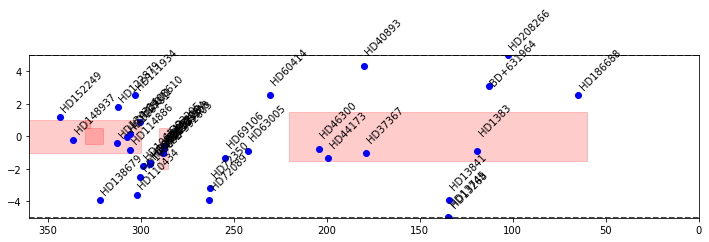

In [50]:
l_min=0
l_max=360
b_min=-5
b_max=5
fig=plt.figure(2,figsize=(12,3))
subplt=plt.subplot(111)
subplt.set_ylim(b_min,b_max)
subplt.set_xlim(l_max,l_min)
labels=[str(180-i*30) for i in range(0,7)]+[str(360-i*30)for i in range(1,7)]
#plt.xticks([180-i*30 for i in range(0,13)],labels)
coords=SkyCoord(ra=ras,dec=decs).galactic
for sightline in [x for x in sightlines if (l_max>x[1]>l_min and b_min<x[2]<b_max)]:
    subplt.plot(sightline[1],sightline[2],'bo')
    subplt.text(sightline[1],sightline[2]+2.5,sightline[0],rotation=45)

subplt.axhline(5,0,1, linestyle='--',c='k')
subplt.axhline(-5,0,1, linestyle='--',c='k')

for survey in surveys:
    rect=patches.Rectangle((survey[0],survey[2]),survey[1]-survey[0],survey[3]-survey[2],color='r',alpha=0.2)
    subplt.add_patch(rect)

In [52]:
cfa_path='/DataDisk/datafiles/PGCC_HST/CO/Columbia-CfA/COGAL_all_raw.fits'
hdulist=fits.open(co_path)
cfa_data=hdulist[0].data
hdr=hdulist[0].header

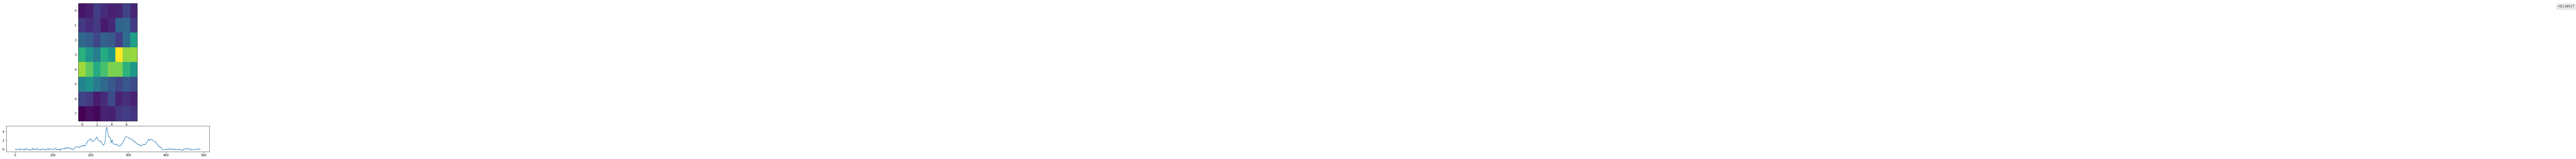

In [53]:
vels=[hdr['CRVAL1']+i*hdr['CDELT1'] for i in range(hdr['NAXIS1'])]

glons=[hdr['CRVAL2']+i*hdr['CDELT2'] for i in range(hdr['NAXIS2'])]
#glons=[x if x>0.0 else x+360. for x in glons]

glats=[hdr['CRVAL3']+i*hdr['CDELT3'] for i in range(-hdr['NAXIS3']/2+1,hdr['NAXIS3']/2+1)]

fig2=plt.figure(3,figsize=(12,9))
G=gridspec.GridSpec(5,2)
subplt3=plt.subplot(G[0:4,:])
subplt4=plt.subplot(G[4,:])
subplt3.plot(sl[1],sl[2], 'ro')
subplt3.text(sl[1]-0.01,sl[2]+0.01,sl[0], bbox=props)
cen_l=0.0
cen_b=0.0
icrs=SkyCoord(l=cen_l*u.degree,b=cen_b*u.degree, frame='galactic').icrs
box=1.0

vel=0
min_vel=vel-20.
max_vel=vel+20.

min_vel_idx=min(range(len(vels)), key=lambda i: abs(vels[i]-min_vel))
max_vel_idx=min(range(len(vels)), key=lambda i: abs(vels[i]-max_vel))

# Isolate a 1x1 deg box around the sightline
min_glon=min(range(len(glons)),key=lambda i: abs(glons[i]-(cen_l+box/2.)))
max_glon=min(range(len(glons)),key=lambda i: abs(glons[i]-(cen_l-box/2.)))
min_glat=min(range(len(glats)),key=lambda i: abs(glats[i]-(cen_b-box/2.)))
max_glat=min(range(len(glats)),key=lambda i: abs(glats[i]-(cen_b+box/2.)))
#print scidata[min_vel_idx:max_vel_idx,min_glon:max_glon,min_glat:max_glat]
dat=np.sum(scidata[min_glat:max_glat,min_glon:max_glon,min_vel_idx:max_vel_idx],axis=2)
cax=subplt3.imshow(dat,aspect=2)
subplt4.plot(scidata[241,1441,:])

In [33]:
print pgcc['gau_position_angle']*180/np.pi

79.4119525362
